# CPSC 330 - Applied Machine Learning 

## Homework 3: Preprocessing 
### Associated lectures: Lectures 4, 5, 6 

**Due date: Saturday, May 28, 2022 at 18:00**

## Table of Contents

- [Instructions](#si)
- [Introduction](#in)
- [Exercise 1: Introducing the dataset](#1)
- [Exercise 2: Exploratory data analysis (EDA)](#2)
- [Exercise 3: Preprocessing](#3)
- [Exercise 4: Building models](#4)
- [Exercise 5: Evaluating on the test set](#5)

## Imports 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

## Instructions <a name="si"></a>
<hr>
rubric={points:6}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2022s/blob/master/docs/homework_instructions.md).

**You may work with a partner on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

_Note: The assignments will get gradually more open-ended as we progress through the course. In many cases, there won't be a single correct solution. Sometimes you will have to make your own choices and your own decisions (for example, on what parameter values to use when they are not explicitly provided in the instructions). Use your own judgment in such cases and justify your choices, if necessary._

## Introduction <a name="in"></a>
<hr>

A crucial step when using machine learning algorithms on real-world datasets is preprocessing. This homework will give you some practice of data preprocessing and building a supervised machine learning pipeline on a real-world dataset. 

<br><br>

## Exercise 1: Introducing the dataset <a name="1"></a>
<hr>

In this lab, you will be working on [the adult census dataset](https://www.kaggle.com/uciml/adult-census-income#). Download the CSV and save it as `adult.csv` locally in this homework folder. 

This is a classification dataset and the classification task is to predict whether income exceeds 50K per year or not based on the census data. You can find more information on the dataset and features [here](http://archive.ics.uci.edu/ml/datasets/Adult).

The starter code below loads the data CSV (assuming that it is saved as `adult.csv` in this folder). 

_Note that many popular datasets have sex as a feature where the possible values are male and female. This representation reflects how the data were collected and is not meant to imply that, for example, gender is binary._

In [2]:
census_df = pd.read_csv("adult.csv")
census_df.shape

(32561, 15)

<br><br>

### 1.1 Data splitting 
rubric={points:4}

In order to avoid violation of the golden rule, the first step before we do anything is splitting the data. 

**Your tasks:**

1. Split the data into `train_df` (50%) and `test_df` (50%) with `random_state = 10`. Keep the target column (`income`) in the splits so that we can use it in the exploratory data analysis.

_Usually having more data for training is a good idea. But here I'm using 50%/50% split because this is kind of a big dataset for a modest laptop. A smaller training data means it won't take too long to train the model on your laptop. A side advantage of this would be that with a bigger test split, we'll have a more reliable estimate of the deployment performance!_

In [3]:
train_df, test_df = train_test_split(census_df, test_size=0.5, random_state=1)

<br><br>

## Exercise 2: Exploratory data analysis (EDA) <a name="2"></a> 
<hr>

Let's examine our `train_df`. 

In [4]:
train_df.sort_index()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
9,41,Private,70037,Some-college,10,Never-married,Craft-repair,Unmarried,White,Male,0,3004,60,?,>50K
10,45,Private,172274,Doctorate,16,Divorced,Prof-specialty,Unmarried,Black,Female,0,3004,35,United-States,>50K
14,51,?,172175,Doctorate,16,Never-married,?,Not-in-family,White,Male,0,2824,40,United-States,>50K
15,46,Private,45363,Prof-school,15,Divorced,Prof-specialty,Not-in-family,White,Male,0,2824,40,United-States,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


We see some missing values represented with a "?". Probably these were the questions not answered by some people during the census.  Usually `.describe()` or `.info()` methods would give you information on missing values. But here, they won't pick "?" as missing values as they are encoded as strings instead of an actual NaN in Python. So let's replace them with `np.nan` before we carry out EDA. If you do not do it, you'll encounter an error later on when you try to pass this data to a classifier. 

In [5]:
train_df_nan = train_df.replace("?", np.nan)
test_df_nan = test_df.replace("?", np.nan)
train_df_nan.shape

(16280, 15)

In [6]:
train_df_nan.sort_index()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
9,41,Private,70037,Some-college,10,Never-married,Craft-repair,Unmarried,White,Male,0,3004,60,NaN,>50K
10,45,Private,172274,Doctorate,16,Divorced,Prof-specialty,Unmarried,Black,Female,0,3004,35,United-States,>50K
14,51,NaN,172175,Doctorate,16,Never-married,NaN,Not-in-family,White,Male,0,2824,40,United-States,>50K
15,46,Private,45363,Prof-school,15,Divorced,Prof-specialty,Not-in-family,White,Male,0,2824,40,United-States,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


The "?" symbols are now replaced with NaN values. 

<br><br>

### 2.1 Visualizing features
rubric={points:10}

**Your tasks:**

1. Examine the information given by `train_df_nan.info()` and `train_df_nan.describe()` methods. In case of `.describe()`, you can optimally use the `include="all"` argument to show summary statistics of all  features.
2. Visualize the histograms of numeric features. 
3. From the visualizations, which features seem relevant for the given prediction task?

> Note: (Optional) If you're feeling excited about this you are welcome to use [`pandas_profiling`](https://github.com/pandas-profiling/pandas-profiling) for more elaborate visualization and EDA. 

In [7]:
train_df_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16280 entries, 436 to 29733
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             16280 non-null  int64 
 1   workclass       15370 non-null  object
 2   fnlwgt          16280 non-null  int64 
 3   education       16280 non-null  object
 4   education.num   16280 non-null  int64 
 5   marital.status  16280 non-null  object
 6   occupation      15368 non-null  object
 7   relationship    16280 non-null  object
 8   race            16280 non-null  object
 9   sex             16280 non-null  object
 10  capital.gain    16280 non-null  int64 
 11  capital.loss    16280 non-null  int64 
 12  hours.per.week  16280 non-null  int64 
 13  native.country  16001 non-null  object
 14  income          16280 non-null  object
dtypes: int64(6), object(9)
memory usage: 2.0+ MB


<br><br>

In [8]:
train_df_nan.describe(include='all')

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
count,16280.000000,15370,1.628000e+04,16280,16280.000000,16280,15368,16280,16280,16280,16280.000000,16280.000000,16280.000000,16001,16280
unique,NaN,8,NaN,16,NaN,7,14,6,5,2,NaN,NaN,NaN,40,2
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,11352,NaN,5196,NaN,7436,2093,6558,13940,10934,NaN,NaN,NaN,14573,12397
mean,38.540356,NaN,1.896478e+05,NaN,10.087899,NaN,NaN,NaN,NaN,NaN,1098.991278,84.079177,40.410135,NaN,NaN
std,13.707150,NaN,1.029629e+05,NaN,2.582876,NaN,NaN,NaN,NaN,NaN,7575.906421,393.381615,12.262002,NaN,NaN
min,17.000000,NaN,1.882700e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,1.183352e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,1.783830e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,48.000000,NaN,2.374830e+05,NaN,13.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


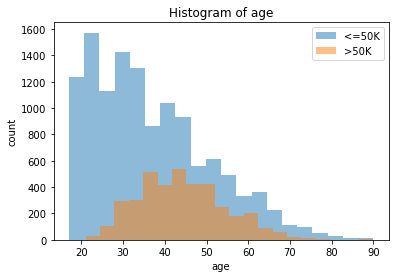

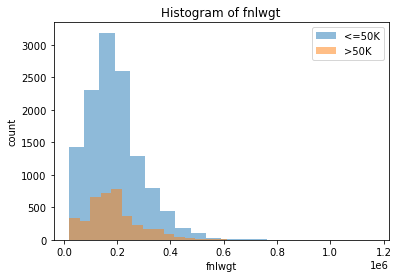

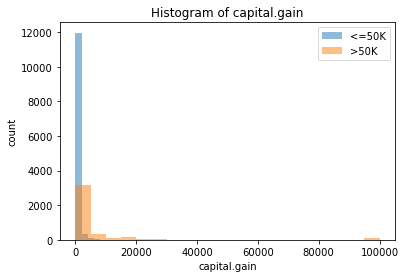

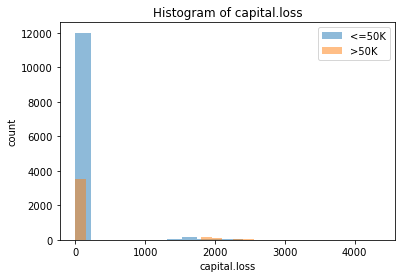

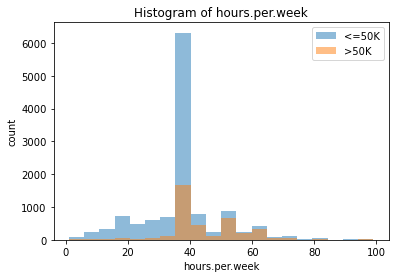

In [9]:
numeric_features = ["age", "fnlwgt", "capital.gain", "capital.loss", "hours.per.week"]

for features in numeric_features:
    plot = train_df_nan.groupby("income")[features].plot.hist(bins=20, alpha=0.5, legend=True)
    plt.title("Histogram of " + features)
    plt.xlabel(features)
    plt.ylabel("count")
    plt.show()

From these visualizations, age seems to be the most relevant feature in making the prediction

### 2.2 Identify transformations to apply
rubric={points:18}

**Your tasks:**
1. Identify the sequence of transformations that you would apply on each column in the dataset and fill in the table below accordingly. An example of the sequence of transformations to be applied on the `occupation` feature is shown in the table below. You may decide not to apply any transformations on a certain column or entirely drop a column from your model. That's totally fine. 
2. Are there common transformations you would like to apply on certain types of features? Identify different feature types for applying different transformations. In particular, fill in the lists below. 
3. Is including the `race` feature for predicting income ethically a good idea? Briefly discuss. 

> Note: This question is a bit open-ended and there is no single correct solution.

| Feature | Transformation |
| --- | ----------- |
| occupation | imputation, OHE |
| age | scaling |
| workclass | imputation, OHE |
| fnlwgt | scaling |
| education | imputation, OHE |
| education.num | scaling |
| marital.status | OHE |
| relationship | imputation, OHE |
| race | OHE |
| sex | OHE |
| capital.gain | scaling |
| capital.loss | scaling |
| hours.per.week | scaling |
| native.country | OHE |


In [10]:
# Fill in the lists below.
# It's OK to keep some of the lists empty or add new lists.
numeric_features = ["age", "fnlwgt", "capital.gain", "capital.loss", "hours.per.week"]
categorical_features = ["workclass", "marital.status", "relationship", "race", "native.country"]
ordinal_features = ["education"]
binary_features = ["sex"]
drop_features = ["education.num"]
passthrough_features = []
target = "income"

OHE is a common transformation which can be applied to categorical features. 

In my opinion, including features that could pose an ethical concern (like race) in building a model should not be used to make predictions. Using these features can also create bias.

<br><br>

### 2.3 Separating feature vectors and targets  
rubric={points:4}

**Your tasks:**

1. Create `X_train`, `y_train`, `X_test`, `y_test` from `train_df_nan` and `test_df_nan`. 
2. At this point, if you train [`sklearn`'s `SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) model on `X_train` and `y_train` would it work? Why or why not?

In [11]:
X_train = train_df_nan.drop(columns=[target])
y_train = train_df_nan[target]

X_test = test_df_nan.drop(columns=[target])
y_test = test_df_nan[target]

Since our data is not preprocessed, training sklearn's model on X_train and y_train would not work at this point.

<br><br><br><br>

## Exercise 3: Preprocessing <a name="3"></a>
<hr>

### 3.1 Preprocessing using `sklearn`'s `ColumnTransformer` and `Pipeline`
rubric={points:18}

Let's carry out preprocessing using `sklearn`'s `ColumnTransformer` and `Pipeline`. Note that you can define pipelines in two ways: 
- by using [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) and explicitly providing named steps
- by using [`make_pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html#sklearn.pipeline.make_pipeline), which automatically names the steps in the pipeline with their class names. 

Similarly you can create a column transformer in two ways:
- by using [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)
- by using [`make_column_transformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html) 

You may use the method of your choice but `make_pipeline` and `make_column_transformer` are highly recommended.  

**Your tasks:**

1. Create a column transformer `preprocessor` based on transformations you want to apply on the data from 2.2. 
2. Transform the data by calling `fit_transform` on the training set. What's the shape of the transformed data? 
3. Why do we need to use a column transformer in this case? Briefly explain. 

In [12]:
preprocessor = None

In [13]:
education_levels = [
    "Preschool",
    "1st-4th",
    "5th-6th",
    "7th-8th",
    "9th",
    "10th",
    "11th",
    "12th",
    "HS-grad",
    "Prof-school",
    "Assoc-voc",
    "Assoc-acdm",
    "Some-college",
    "Bachelors",
    "Masters",
    "Doctorate",
]

In [14]:
num_transformer = make_pipeline(StandardScaler())

cat_transformer = make_pipeline(SimpleImputer(strategy="constant", fill_value="missing"), OneHotEncoder(sparse=False, handle_unknown="ignore"))

ord_transformer = OrdinalEncoder(categories=[education_levels])

bin_transformer = make_pipeline(SimpleImputer(strategy="constant", fill_value="missing"), OneHotEncoder(handle_unknown="ignore"))

preprocessor = make_column_transformer( (num_transformer, numeric_features), (cat_transformer, categorical_features), (ord_transformer, ordinal_features), (bin_transformer, binary_features), ("drop", drop_features) )

In [15]:
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['age', 'fnlwgt', 'capital.gain',
                                  'capital.loss', 'hours.per.week']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['workcla...
                                                             '7th-8th', '9th',
                                                             '10th', '11th',
                                                             '12th', 'HS-grad',
                                                             'Prof-school',
                                                             'Assoc-voc',
                                                             'Assoc-acdm',
                                                             'Some-college',
                                                             'Bachelors',
                                                             'Masters',
                                                             'Doctorate']]),
                                 ['education']),
                                ('pipeline-3',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['sex']),
                                ('drop', 'drop', ['education.num'])])

In [16]:
preprocessor_fit = preprocessor.fit_transform(X_train, y_train)

In [17]:
preprocessor_fit.shape

(16280, 76)

column transformer is used because different transformations are being applied to different columns.

<br><br><br><br>

## Exercise 4: Building models <a name="4"></a>
<hr>

Now that we have preprocessed features, we are ready to build models. Below, I'm providing the function we used in class which returns mean cross-validation score along with standard deviation for a given model. Feel free to use it to keep track of your results if you like. 

In [18]:
results_dict = {}  # dictionary to store all the results

In [19]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

<br><br>

### 4.1 Baseline model 
rubric={points:6}

**Your tasks:**
1. Define a pipeline with two steps: `preprocessor` from 3.1 and `scikit-learn`'s `DummyClassifier` with `strategy="prior"` as your classifier.  
2. Carry out 5-fold cross-validation with the pipeline. Store the results in `results_dict` above. Display the results as a pandas DataFrame.  

> You may use the function `mean_std_cross_val_scores` above to carry out cross-validation and storing results. Refer to the class notes if you are unsure about how to use it. 

In [20]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="prior")
pipe = make_pipeline(preprocessor, dummy)
results_dict["dummy"] = mean_std_cross_val_scores(
    pipe, X_train, y_train, cv=5, return_train_score=True
)
pd.DataFrame(results_dict)

,dummy
fit_time,0.035 (+/- 0.004)
score_time,0.015 (+/- 0.002)
test_score,0.761 (+/- 0.000)
train_score,0.761 (+/- 0.000)


<br><br>

### 4.2 Trying different classifiers
rubric={points:14}

**Your tasks:**

1. For each of the models in the starter code below: 
    - Define a pipeline with two steps: `preprocessor` from 3.1 and the model as your classifier. 
    - Carry out 5-fold cross-validation with the pipeline.  
    - Store the results in `results_dict`. 
2. Display all the results so far as a pandas dataframe. 
3. Compare the train and validation accuracies and `fit` and `score` times in each case. How do the the validation accuracies compare to the baseline model from 4.1? Which model has the best validation accuracy? Which model is the fastest one?  

> Note that this might take a while to run.

> You may use the function above `mean_std_cross_val_scores` to carry out cross-validation and storing results. Refer to the class notes if you are unsure about how to use it. 

In [21]:
models = {
    "decision tree": DecisionTreeClassifier(),
    "kNN": KNeighborsClassifier(),
    "RBF SVM": SVC(),
}

In [22]:
for name, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    results_dict[model] = mean_std_cross_val_scores(pipe, X_train, y_train, cv=5, return_train_score=True)

In [23]:
pd.DataFrame(results_dict)

,dummy,DecisionTreeClassifier(),KNeighborsClassifier(),SVC()
fit_time,0.035 (+/- 0.004),6.173 (+/- 0.527),0.037 (+/- 0.001),3.478 (+/- 0.062)
score_time,0.015 (+/- 0.002),0.015 (+/- 0.001),0.154 (+/- 0.017),2.734 (+/- 0.056)
test_score,0.761 (+/- 0.000),0.800 (+/- 0.004),0.825 (+/- 0.005),0.842 (+/- 0.004)
train_score,0.761 (+/- 0.000),1.000 (+/- 0.000),0.877 (+/- 0.002),0.843 (+/- 0.001)


Observations: 

SVC has the best validation accuracy, followed by kNN and decision tree. Decision tree is significantly faster than kNN and SVC. It can be seen that decision tree exactly overfits training data.
    

<br><br>

### (optional) 4.3 Exploring importance of scaling
rubric={points:1}

In this exercise you'll examine whether scaling helps in case of KNNs and SVM RBFs. 

**Your tasks:**

1. Create a column transformer without the `StandardScaler` step for `numeric_features`. 
2. Repeat the steps in 4.2 with this new column transformer. 
3. Compare the results of scaled numeric features with unscaled numeric features. Is scaling necessary for decision trees? Why or why not?

### 4.4 Hyperparameter optimization
rubric={points:10}

In this exercise, you'll carry out hyperparameter optimization for the hyperparameter `C` of SVC RBF classifier. In practice you'll carry out hyperparameter optimization for all different hyperparameters for the most promising classifiers. For the purpose of this assignment, we'll only do it for the `SVC` classifier with one hyperparameter: `C`. 

**Your tasks:**

1. For each `C` value in the `param_grid` in the starter code below: 
    - Create a pipeline object with two steps: preprocessor from 3.1 and `SVC` classifier with the value of `C`.
    - Carry out 5-fold cross validation with the pipeline.  
    - Store the results in `results_dict` and display results as a pandas DataFrame. 
2. The hyperparameter `C = 1.0` is the default value in `scikit-learn`. Does this default value (`C = 1.0`) seem reasonable, meaning it is performing the best or comparable to the best `C` values?

> Note: Running this might take a while. 

In [24]:
param_grid = {"C": np.logspace(-2, 2, 5)}
param_grid

{'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])}

In [25]:
for param in param_grid["C"]:
    name = "RBF SVC"
    pipe = make_pipeline(preprocessor, SVC(C=param))
    
    key = name + "(C= " + str(param) + ")"
    results_dict[key] = mean_std_cross_val_scores(pipe, X_train, y_train, cv=5, return_train_score=True)
    
results = pd.DataFrame(results_dict)
results

,dummy,DecisionTreeClassifier(),KNeighborsClassifier(),SVC(),RBF SVC(C= 0.01),RBF SVC(C= 0.1),RBF SVC(C= 1.0),RBF SVC(C= 10.0),RBF SVC(C= 100.0)
fit_time,0.035 (+/- 0.004),6.173 (+/- 0.527),0.037 (+/- 0.001),3.478 (+/- 0.062),4.922 (+/- 0.501),4.115 (+/- 0.421),3.481 (+/- 0.028),3.953 (+/- 0.066),6.047 (+/- 0.362)
score_time,0.015 (+/- 0.002),0.015 (+/- 0.001),0.154 (+/- 0.017),2.734 (+/- 0.056),3.623 (+/- 0.377),3.027 (+/- 0.033),2.759 (+/- 0.070),2.488 (+/- 0.129),2.588 (+/- 0.046)
test_score,0.761 (+/- 0.000),0.800 (+/- 0.004),0.825 (+/- 0.005),0.842 (+/- 0.004),0.766 (+/- 0.001),0.827 (+/- 0.005),0.842 (+/- 0.004),0.843 (+/- 0.005),0.841 (+/- 0.005)
train_score,0.761 (+/- 0.000),1.000 (+/- 0.000),0.877 (+/- 0.002),0.843 (+/- 0.001),0.767 (+/- 0.000),0.828 (+/- 0.001),0.843 (+/- 0.001),0.847 (+/- 0.001),0.853 (+/- 0.001)


<br><br><br><br>

## Exercise 5: Evaluating on the test set <a name="5"></a>
<hr>

Now that we have a best performing model, it's time to assess our model on the set aside test set. In this exercise you'll examine whether the results you obtained using cross-validation on the train set are consistent with the results on the test set. 

### 5.1 Scoring on the unseen test set 
rubric={points:10}

**Your tasks:**

1. Train the best performing model on the entire training set. 
2. Report the results of this model on `X_test`. 
3. Are the cross-validation results and test results consistent? 

In [26]:
pipeline = make_pipeline(preprocessor, SVC(C=1.0))
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.8473680977826915

There is a high consistency between cross-validation results and test results.

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 

Congratulations on finishing the homework! This was a tricky one but I hope you are feeling good after working on it. You are now ready to build a simple supervised machine learning pipeline on real-world datasets! Well done!